In [ ]:
!pip install wntr matplotlib numpy viswaternet

# Overview

In this Jupyter Notebook, our goal is to explore different model representation and visualization options provided by WNTR as well as Python packages that build on WNTR. This is our agenda:

1. Demonstrate WNTR skeletonization
2. Demonstrate model reduction using the package MAGNets
3. Use WNTR for visualization
4. Explore network visualization options provided by VisWaterNet

For our analyses, we will use BWFLNet, a model of a real water distribution network. The Bristol Water Field Lab (BWFL) network is part of the water distribution network of the city of Bristol, UK, and it serves approximately 8,000 customer connections. BWFLnet is an operational network in Bristol, UK, operated by Bristol Water. The data provided is a the product of a long term research partnership between Bristol Water and Infrasense Labs at Imperial College London.

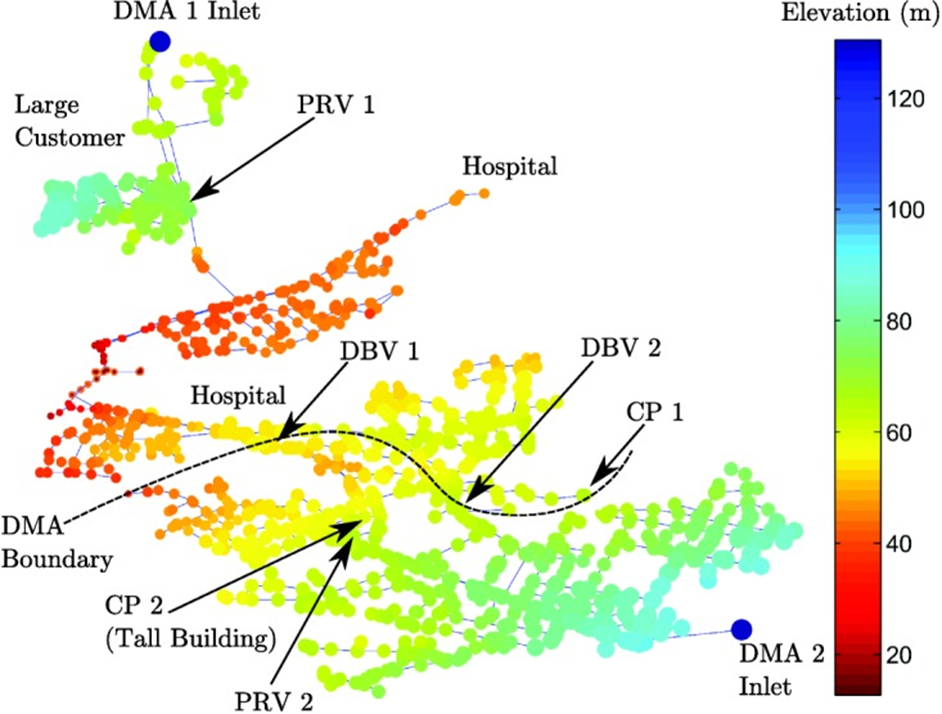

Let us begin by importing in the INP file of the model. Note that this model has been slightly modified from the original model in the following ways:
1. some demand patterns are exactly the same as others so we have merged them
2. all TCVs in the model have been replaced with equivalent pipes

Our first step is to import the Python packages we need into this file:

In [45]:
#import packages
import wntr
import matplotlib.pyplot as plt
import numpy as np
import time

We now define the INP file and initialize a water network model object using WNTR.

In [46]:
#import bwfl
inp = 'Networks/BWFLnet_modified.inp'

wn = wntr.network.WaterNetworkModel(inp)

We will now run a hydraulic simulation with WNTR (using the EPANET 2.2 engine), store the simulation time, and examine the number of compenents in the network.

In [48]:
#run wntr simulation
sim = wntr.sim.EpanetSimulator(wn)

t1 = time.time()
results = sim.run_sim()
t2 = time.time()

simtime = t2-t1
print('The simulation run time was ', simtime, 's')

#describe the number of components in the system
wn.describe()

The simulation run time was  0.4879791736602783 s


{'Nodes': 2548,
 'Links': 2606,
 'Patterns': 9,
 'Curves': 0,
 'Sources': 0,
 'Controls': 0}

Remember that this real network has several important junctions that we must keep track of. Here, we define (1) a list of junction names representing locations of pressure sensors, and (2) a list of junctions that are assigned different demand patterns as well as their neighboring nodes.

In [108]:
#list of junctions where pressure sensors are installed
pressure_sensors_list = ['node_1925', 'node_1938', 'node_1961', 'node_1971', 
                         'node_1983', 'node_0354', 'node_2012', 'node_2046', 
                         'node_2113', 'node_0785', 'node_2188', 'node_2197', 
                         'node_2210', 'node_2243', 'node_2265', 'node_2285', 
                         'node_1194', 'node_1202', 'node_2354', 'node_2428', 
                         'node_2440', 'node_2441', 'node_1738', 'node_2485', 
                         'node_1781', 'node_1876', 'node_2535']

#list of junctions with different demand patterns ...
diff_demand_pattern_list = ['node_0640', 'node_0870', 'node_0973', 'node_1122', 'node_1311', 
                            'node_1363', 'node_1388', 'node_1685', 'node_1813', 'node_2125', 
                            'node_2130', 'node_2167', 'node_2184', 'node_2220', 'node_2307']

# ... and their neighbors
diff_demand_neighbor_list = ['node_0595', 'node_0647', 'node_0648', 'node_2168', 'node_2152', 
                             'node_0907', 'node_0952', 'node_2199', 'node_2206', 'node_1121',
                             'node_2260', 'node_1315', 'node_1340', 'node_2350', 'node_1385',
                             'node_1386', 'node_1402', 'node_2439', 'node_2446', 'node_2456',
                             'node_1807', 'node_0718', 'node_2140', 'node_2112', 'node_0755',
                             'node_0890', 'node_0868', 'node_0913', 'node_0984', 'node_1037',
                             'node_1223', 'node_1262']

critical_nodes = pressure_sensors_list + diff_demand_pattern_list + diff_demand_neighbor_list

# Model Reduction Using WNTR

We see that the BWFLNet model has over 2500 nodes and links. Hydraulic models of complex water networks, such as this one, can be expensive to run in terms of computational effort and time. Therefore, we can turn to **skeletonized** or **reduced** models to speed up model running times and facilitate real-time decision making. Model reduction refers to the method of reducing the size of a network model to an equivalent model with fewer components and similar accuracy. 

Here, we will first demonstrate WNTR's skeletonization function which allows users to specify if they would like to remove or merge dead-end pipes, pipes connected in series, and pipes connected in parallel. A required function argument is the ```pipe_diameter_threshold```: all pipes with diameters <= this diameter are candidates for removal.

Let us call on the WNTR ```skeletonize``` function to remove pipes with a diameter less than 3 ft from the model and check how many components remain.

In [59]:
#skeletonize model using WNTR
wn2 = wntr.morph.skeletonize(wn, pipe_diameter_threshold = 0.254*3)

wn2.describe()

{'Nodes': 1398,
 'Links': 1454,
 'Patterns': 9,
 'Curves': 0,
 'Sources': 0,
 'Controls': 0}

This model is about half the size of the original model! Let's see how much faster the reduced model runs compared to the original model.

In [69]:
#run wntr simulation
sim2 = wntr.sim.EpanetSimulator(wn2)
t1 = time.time()
results2 = sim2.run_sim()
t2 = time.time()

simtime2 = t2 - t1
print('The simulation run time for the reduced model was ', simtime2, 's, which is ', str(round(simtime2/simtime, 2)),
      ' times faster than the original model.')

The simulation run time for the reduced model was  0.29481053352355957 s, which is  0.6  times faster than the original model.


We will now generate some plots to confirm that the pressures at junctions remaining in the reduced model are, indeed, equivalent to the pressures at the same junctions in the original model. Let us pick two nodes at locations of pressure sensors and plot time series pltos for WNTR simulation results for both the original and skeletonized model junction pressure heads.

Text(0.5, 0, 'Time [hr]')

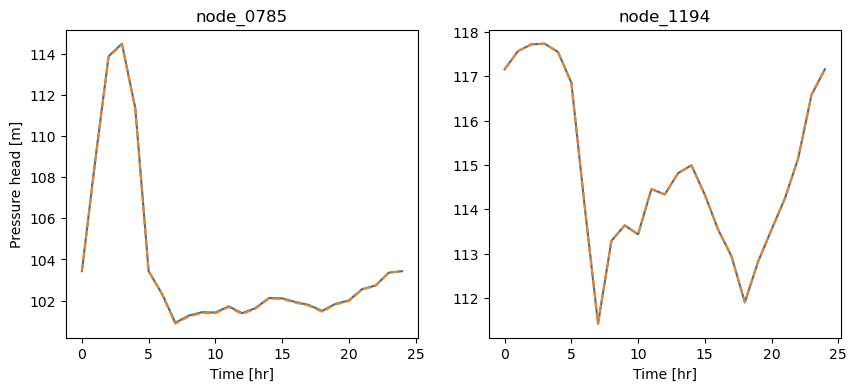

In [100]:
#create plots for the regular and skeletonized networks comparing the head at two different nodes: 
node1, node2 = 'node_0785', 'node_1194'


#obtain head data for each network
head=results.node['head']
head2=results2.node['head']

#obtain data for critical node 1
head_at_node1 = head.loc[:,node1]
reduced_head_at_node1 = head2.loc[:,node1]

#obtain data for critical node 2
head_at_node2 = head.loc[:,node2]
reduced_head_at_node2 = head2.loc[:,node2]

#plot reduced and original model pressure head time series at two critical nodes 
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(head_at_node1.index/3600, head_at_node1)
ax[0].plot(reduced_head_at_node1.index/3600, reduced_head_at_node1, linestyle = '--')
ax[0].set_title(node1)
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Pressure head [m]')

ax[1].plot(head_at_node2.index/3600, head_at_node2)
ax[1].plot(reduced_head_at_node2.index/3600, reduced_head_at_node2, linestyle = '--')
ax[1].set_title(node2)
ax[1].set_xlabel('Time [hr]')

# Network Visualization Using WNTR

Now that we have established that junction pressures in the reduced model closely match those of the equivalent junctions in the original model, let us look at how the network layouts of the two models. We start by using WNTR's ```plot_network``` function to visualize the two models side by side.

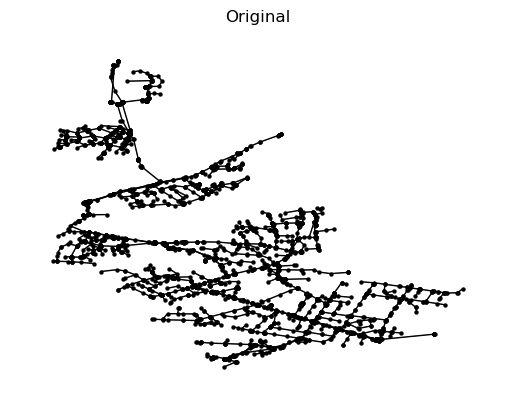

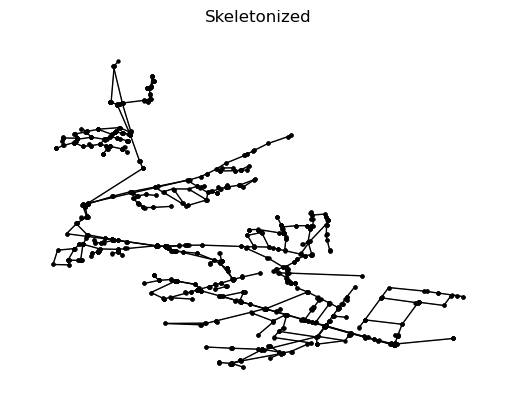

<AxesSubplot:title={'center':'Skeletonized'}>

In [125]:
#water network plots
#fig, ax = plt.subplots(1, 2, figsize=(10,5)) #todo: convert to subplots
wntr.graphics.plot_network(wn, node_size=10, title='Original')
wntr.graphics.plot_network(wn2, node_size=10, title='Skeletonized')

Let us try to add red markers to these plots to indicate locations of critical junctions.

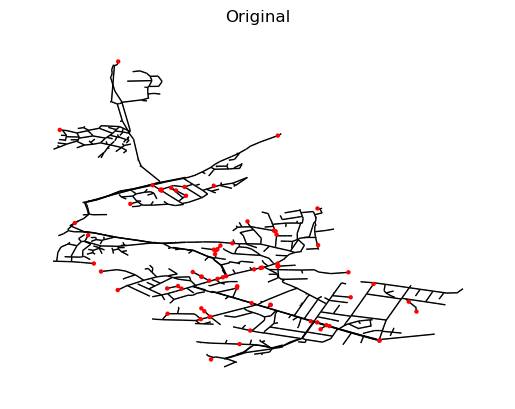

NetworkXError: Node 'node_1925' has no position.

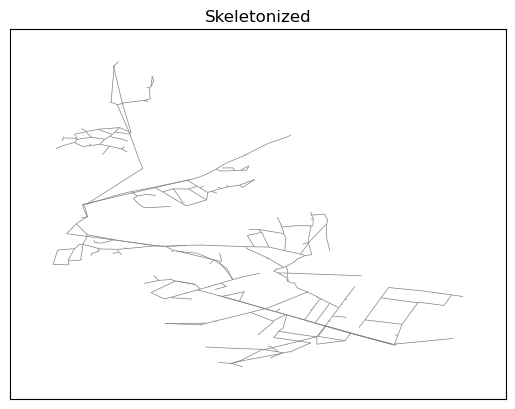

In [121]:
#water network plots
wntr.graphics.plot_network(wn, node_attribute = critical_nodes, node_size=10, title='Original')
wntr.graphics.plot_network(wn2, node_attribute = critical_nodes, node_size=10, title='Skeletonized')

It looks like not all of the critical nodes were left in the reduced model! Let us confirm:

In [123]:
#check if all pressure sensor nodes are present in the reduced model
print('Number of critical nodes: ', len(critical_nodes))

crit_nodes_in_rm = 0
for junction_name in critical_nodes:
    if junction_name in wn2.junction_name_list:
        crit_nodes_in_rm += 1
        
print('Number of critical nodes in reduced model: ', crit_nodes_in_rm)

Number of critical nodes:  74
Number of critical nodes in reduced model:  18


It appears that not all of the critical nodes remain in the reduced model. Additionally, while the red markers can indicate the location of all critical nodes in the network, it is difficult to differentiate between the pressure sensor junctions and junctions with irregular demand patterns.

We will now look into a couple of other Python-based tools that build on WNTR to offer advanced model reduction and visualization capabilities.

# Model Reduction Using MAGNets

Let us start with the Python package MAGNets (Model AGgregation and reduction of water distribution Networks). MAGNets is a Python package designed to perform the reduction and aggregation of water distribution network models. The software is capable of reducing a network around an optional operating point and allows the user to customize which junctions they would like retained in the reduced model as well as the level of reduction. MAGNets' reduction approach is based on the variable elimination method proposed by [Ulanicki et al (1996)](https://www.researchgate.net/publication/273796660_Simplification_of_Water_Distribution_Network_Models).

We first import the MAGNets Python package into the file.

In [126]:
import magnets as mg

The user can then call on the following function to reduce a hydraulic model of a water distribution network. 

```wn2 = mg.reduction.reduce_model(inp_file, op_pt, nodes_to_keep, max_nodal_degree, save_filename)```

The parameters of the `reduce_model` function are described as follows:

`inp_file`: the EPANET-compatible .INP file of the water distribution network model.

`op_pt`: (optional, default = 0) the operating point, or the reporting time step of the hydraulic simulation at which the non-linear headloss equations are linearized.

`nodes_to_keep`: (optional, default = []) a list of nodes the user wishes to retain in the reduced model.

`max_nodal_degree`: (optional, default = None) the maximum nodal degree of nodes being removed from the model. The nodal degree of a node is equal to the number of pipes incident to the node.

`save_filename`: (optional, default = None) a user-specified name assigned to the newly generated .INP file of the reduced model.

`wn2` contains the water network model object of the reduced model. A .INP file of the reduced model is also written into the directory that contains the .INP file of the original network.

Let us see what MAGNets is capable of. We first specify a nodal degree of 1, an operating point of 0, and specify that we would like to retain all critical nodes in the reduced model.

In [128]:
# reduce model using magnets

#define inp_file
inp = 'Networks/BWFLnet_modified.inp'

#specify operating point, nodes to keep
op_pt = None

#max nodal degree = 1
max_nodal_degree1=1
#call model reduction
t1 = time.time()
mg1 = mg.reduction.reduce_model(inp, op_pt, critical_nodes, max_nodal_degree1, save_filename = 'Networks/BWFLnet_modified_level1')
t2 = time.time()

c:\users\mst2245\box sync\research\4. model reduction\magnets\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


# Network Visualization Using VisWaterNet

Here, we introduce another new tool: VisWaterNet, a Python package for easy generation and customization of water distribution network visualizations. VisWaterNet allows for the plotting of continuous, discrete, and categorical data, as well as custom data provided by the user (either through a list imported into the script or an Excel file). Below is a description of the different VisWaterNet functions: 

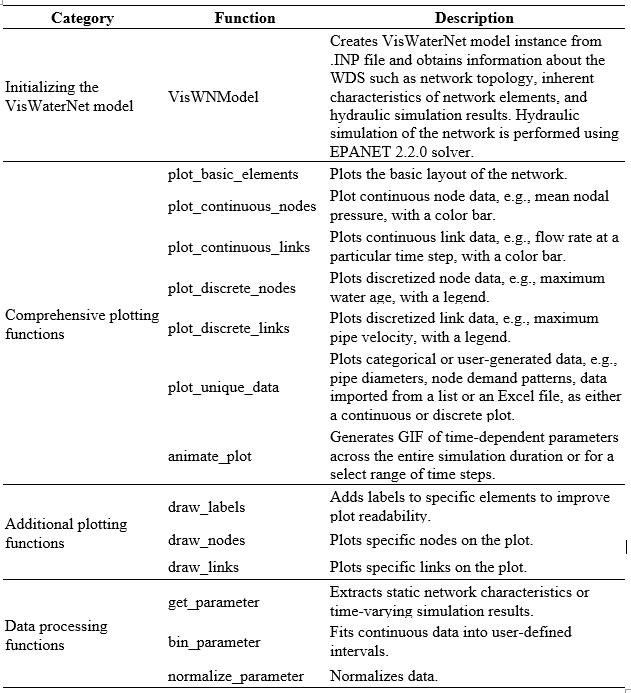

We will use VisWaterNet ```plot_basic_elements``` function to plot original and reduced model network layouts, and use the ```draw_nodes``` function to highlight the location of our critical nodes.

Total reduction time: 4.68 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  1425 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  1480 


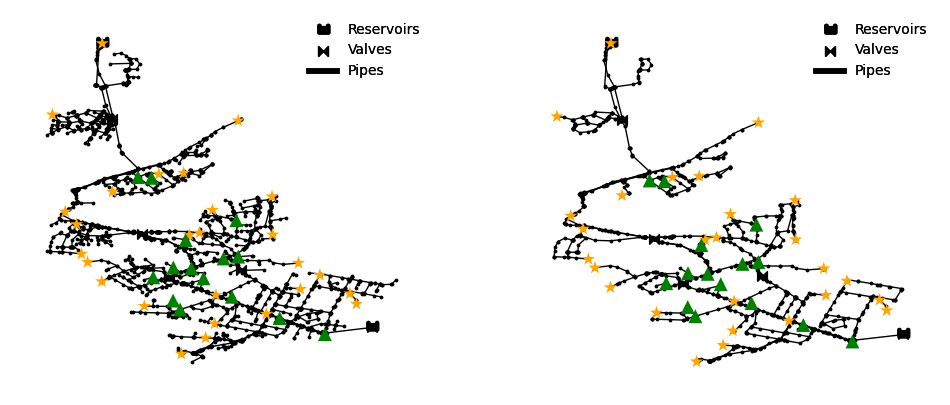

In [137]:
#plot full and reduced networks using diff nodal degrees

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3, reservoir_size = 50, valve_size = 50, base_legend_label_font_size = 10)
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color='orange', node_shape ='*')
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color='green', node_shape ='^')

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_level1.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3, reservoir_size = 50, valve_size = 50, base_legend_label_font_size = 10)
model1.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color='orange', node_shape ='*')
model1.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color='green', node_shape ='^')

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", mg1.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", mg1.num_pipes, "\033[0;0m")

# To be completed

c:\users\mst2245\box sync\research\4. model reduction\magnets\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


Total reduction time: 19.45 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  155 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  201 


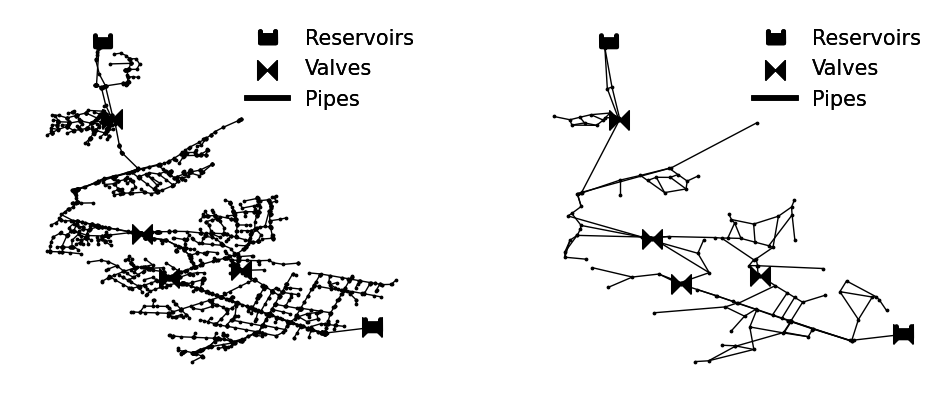

In [33]:
#max nodal degree 2
max_nodal_degree2 = 2

#call model reduction
t1 = time.time()
wn3 = mg.reduction.reduce_model(inp, op_pt, pressure_sensors_list, max_nodal_degree2, 'Networks/BWFLnet_modified_level2')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_level2.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3)

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn3.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn3.num_pipes, "\033[0;0m")

c:\users\mst2245\box sync\research\4. model reduction\magnets\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


Total reduction time: 20.95 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  86 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  145 


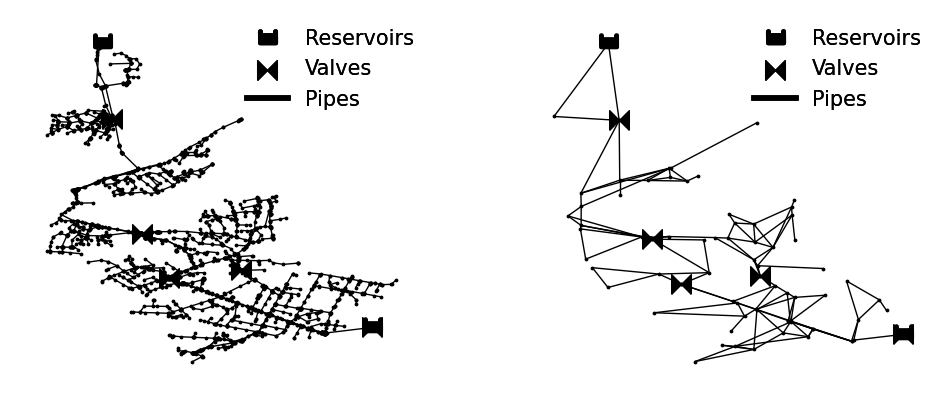

In [36]:
#max nodal degree 3
max_nodal_degree3 = 3

#call model reduction
t1 = time.time()
wn4 = mg.reduction.reduce_model(inp, op_pt, pressure_sensors_list, max_nodal_degree3, 'Networks/BWFLnet_modified_level3')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_level3.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3)

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn4.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn4.num_pipes, "\033[0;0m")

c:\users\mst2245\box sync\research\4. model reduction\magnets\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


Total reduction time: 18.83 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  37 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  142 


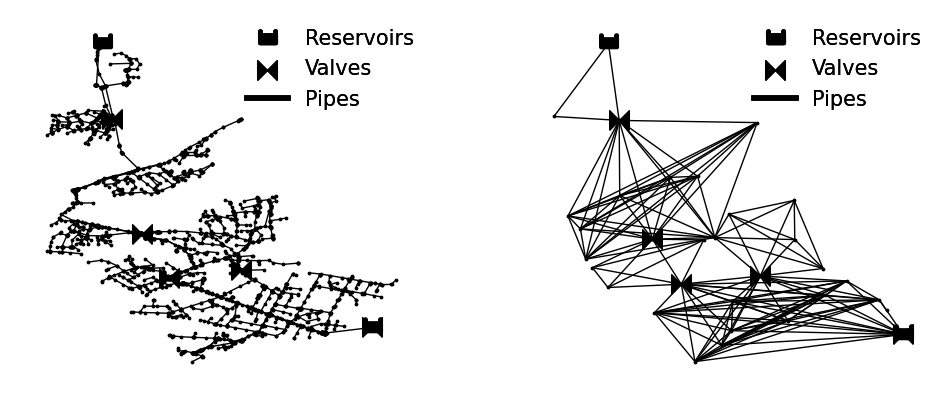

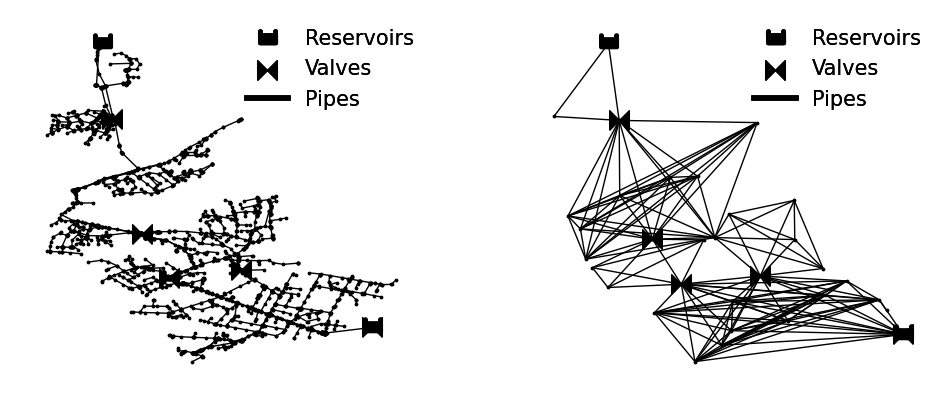

In [40]:
#max nodal degree = none
max_nodal_degree = None

#call model reduction
t1 = time.time()
wn5 = mg.reduction.reduce_model(inp, op_pt, pressure_sensors_list, max_nodal_degree,'Networks/BWFLnet_modified_full')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_full.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3)

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_full.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3)

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn5.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn5.num_pipes, "\033[0;0m")

In [ ]:
# magnets: add time series comparisons

In [138]:
# magnets: add comparison of different operating points?

In [139]:
# viswaternet: plot discrete - nodes - pressure - mean

In [140]:
# viswaternet: plot unique_data - links - excel data - pipe materials

In [ ]:
# viswaternet: plot animation of trace from reservoir